In [2]:
import matplotlib.pyplot as plt

def plot(image, **args):
    plt.figure(figsize=(20, 15))
    return plt.imshow(image, **args)

def read_img(file):
    img_bgr = cv2.imread(file)
    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

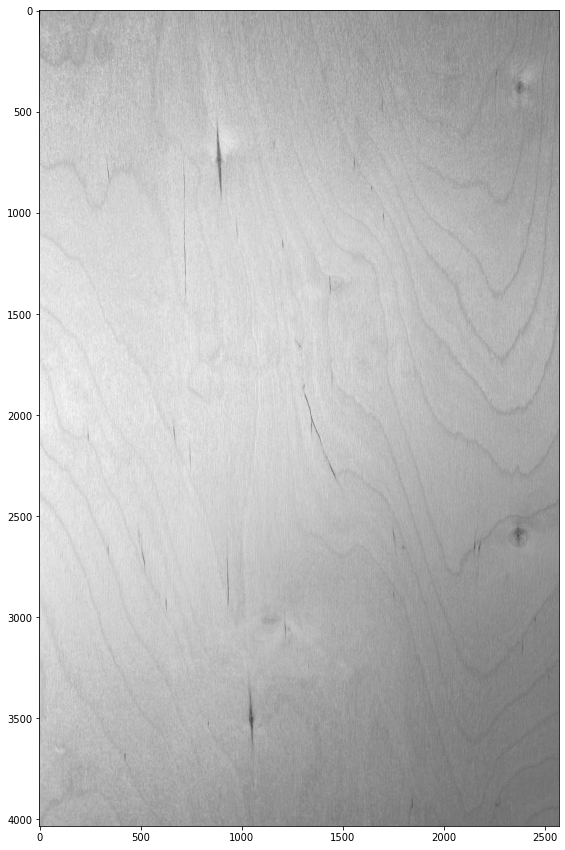

In [3]:
import numpy as np
import cv2

gray = read_img("images/cropartlight2-f.jpg")

plot(gray, cmap='gray')

### Cropping function (not the best since it still leaves black space if the board is not perfectly rectangular)

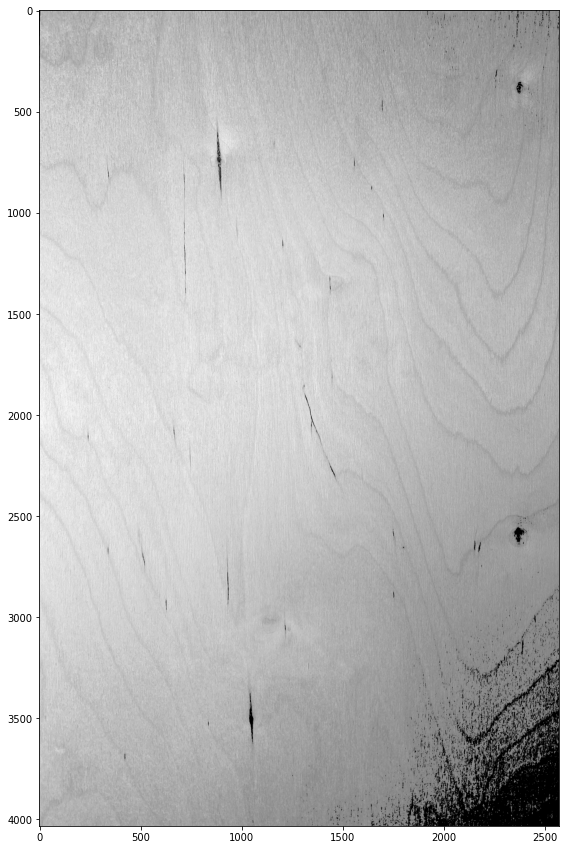

In [4]:
def crop(img_bgr):
    thresh = cv2.threshold(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY), 127, 255, cv2.THRESH_TOZERO)[1]
    bb = cv2.boundingRect(thresh)
    x, y, w, h = bb
    return thresh[y:y+h, x:x+w]

img_bgr = cv2.imread("images/cropartlight2-f.jpg")

foreground = crop(img_bgr)
plot(foreground, cmap="gray")

### Simple Binary Threshold

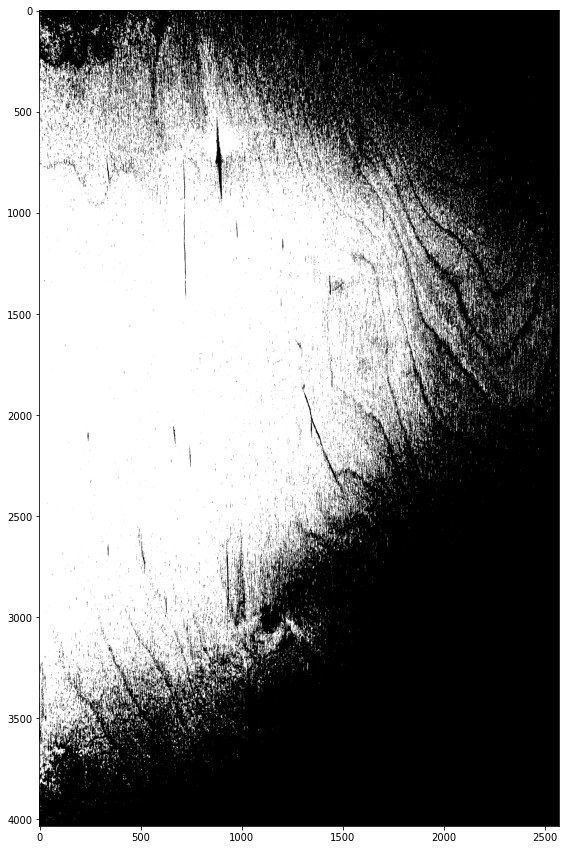

In [5]:
thresh = cv2.threshold(foreground, 190, 255, cv2.THRESH_BINARY)[1]
plot(thresh, cmap="gray")

### Adaptive Threshold

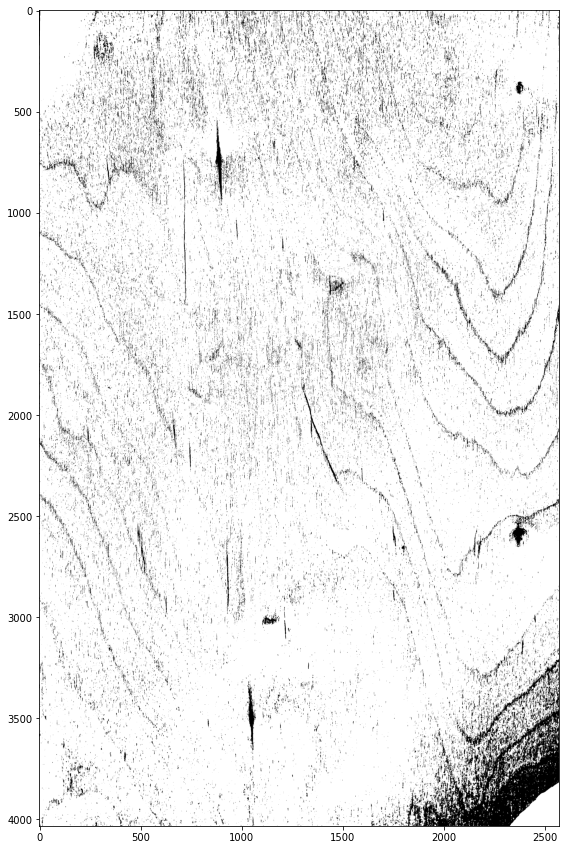

In [6]:
thresh = cv2.adaptiveThreshold(foreground, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 555, 14)
plot(thresh, cmap="gray")

In [7]:
thresholds = []

for i in range(55, 2455, 200):
    thresh = cv2.adaptiveThreshold(foreground, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, i, 14)
    thresholds.append(thresh)

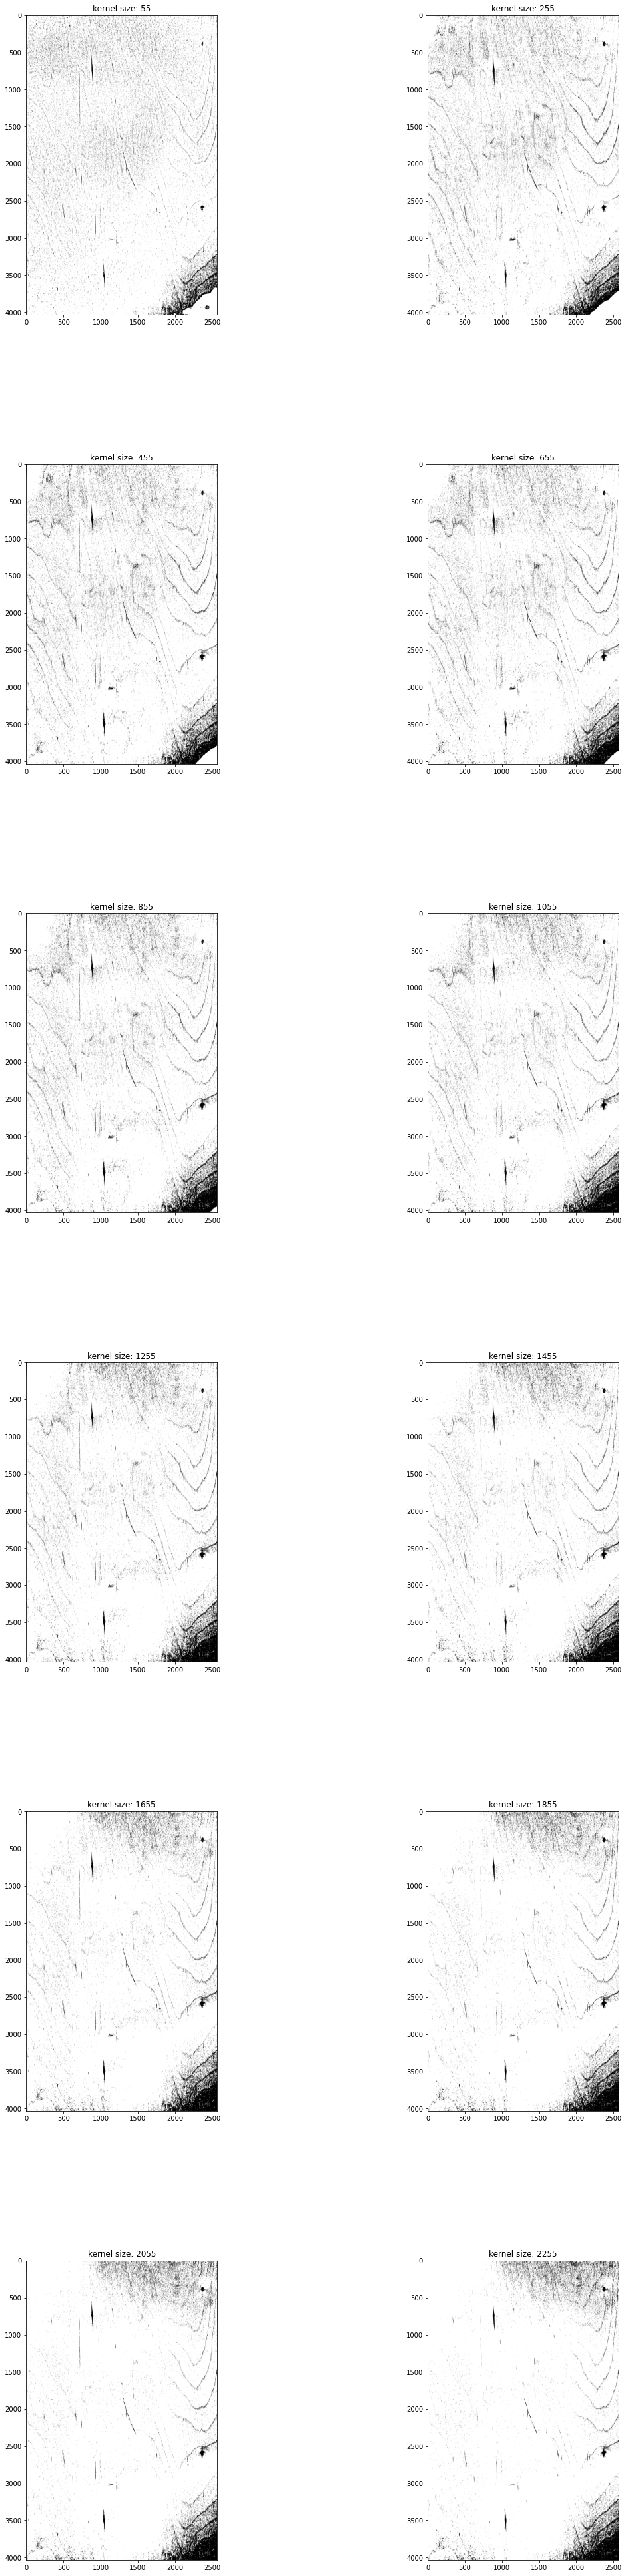

In [8]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
 
fig = plt.figure()
 
fig.set_figheight(120)
fig.set_figwidth(18)
 
spec = gridspec.GridSpec(10, 2, wspace=0.5, hspace=0.5)

for i in range(len(thresholds)):
    ax = fig.add_subplot(spec[i])
    ax.imshow(thresholds[i], "gray")
    ax.set_title("kernel size: " + str(i * 200 + 55))


plt.show()


### Cleaning Up Good Wood

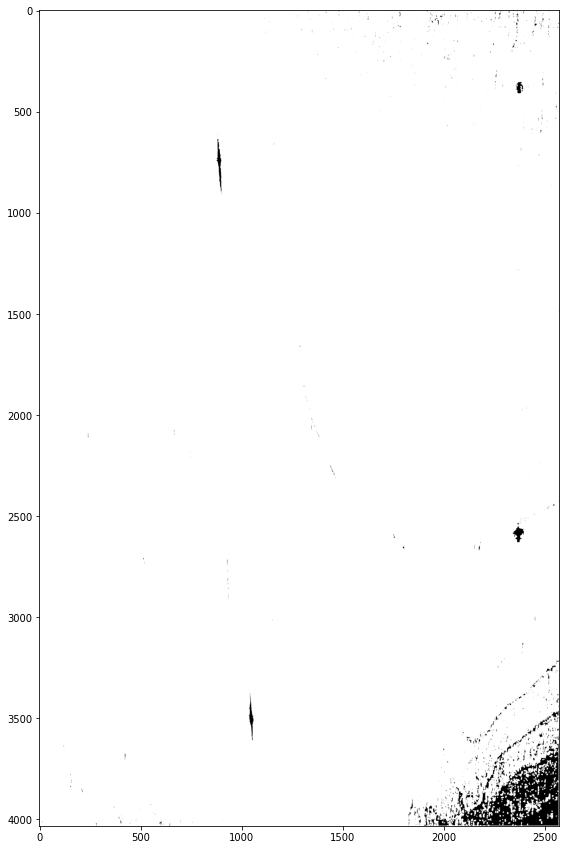

In [9]:

def eliminate_based_on_neighbors(img, nneighbors):
    tbool = img == 0  # True if black

    height = tbool.shape[0]
    width = tbool.shape[1]

    top_left = np.pad(tbool[0:height-1, 0:width-1], ((1, 0), (1, 0)))
    top = np.pad(tbool[0:height-1, 0:width], ((1, 0), (0, 0)))
    top_right = np.pad(tbool[0:height-1, 1:width], ((1, 0), (0, 1)))
    left = np.pad(tbool[0:height, 0:width-1], ((0, 0), (1, 0)))
    right = np.pad(tbool[0:height, 1:width], ((0, 0), (0, 1)))
    bottom_left = np.pad(tbool[1:height, 0:width-1], ((0, 1), (1, 0)))
    bottom = np.pad(tbool[1:height, 0:width], ((0, 1), (0, 0)))
    bottom_right = np.pad(tbool[1:height, 1:width], ((0, 1), (0, 1)))

    stacked = np.dstack((top_left, top, top_right, left, right, bottom_left, bottom, bottom_right))

    black_neighbor_count = np.sum(stacked, axis=2)

    return black_neighbor_count * tbool < nneighbors

new_img = eliminate_based_on_neighbors(thresh, 8)
new_img = eliminate_based_on_neighbors(new_img, 8)
plot(new_img, cmap="gray")

0 0 841.9 595.3
(4032, 2568)
213.8992042440318 214.0


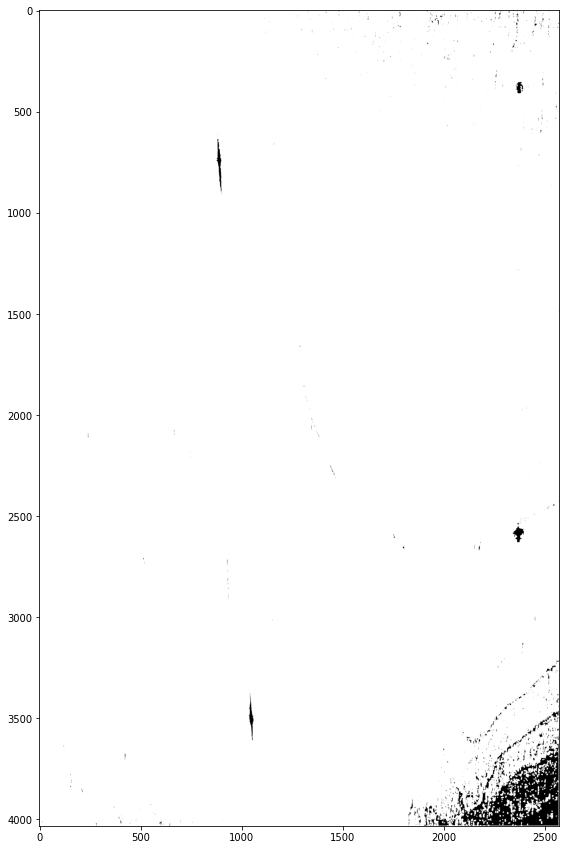

In [10]:
import svg_parser
import EnhancedPath

# file = "autoreconstruction/autoreconstruction/004-train/train2.svg"
file = "autoreconstruction/autoreconstruction/002-plane(FW190D)/plane(FW190D).svg"
paths, viewbox = EnhancedPath.read_svg(file)

closed_paths, endpoints_and_paths = svg_parser.endpoints(paths)
parts = svg_parser.match(endpoints_and_paths)
grouped = svg_parser.group_parts(closed_paths + parts)

i = 0
output_files = []
for path in grouped: 
    filename = "output" + str(i) + ".svg"
    path.write_svg(filename=filename, viewbox=viewbox)
    output_files.append(filename)
    i += 1


print(viewbox)
print(new_img.shape)
print(new_img.shape[0] / 18.85, new_img.shape[1] / 12)

plot(new_img, cmap="gray")


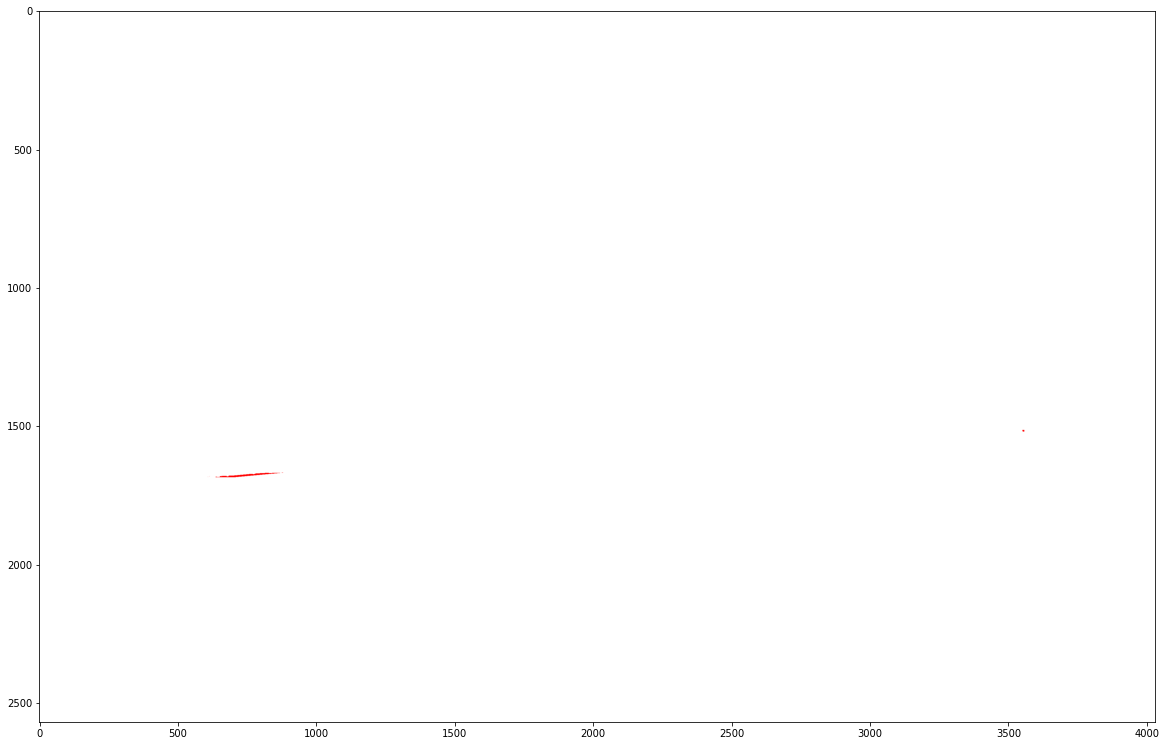

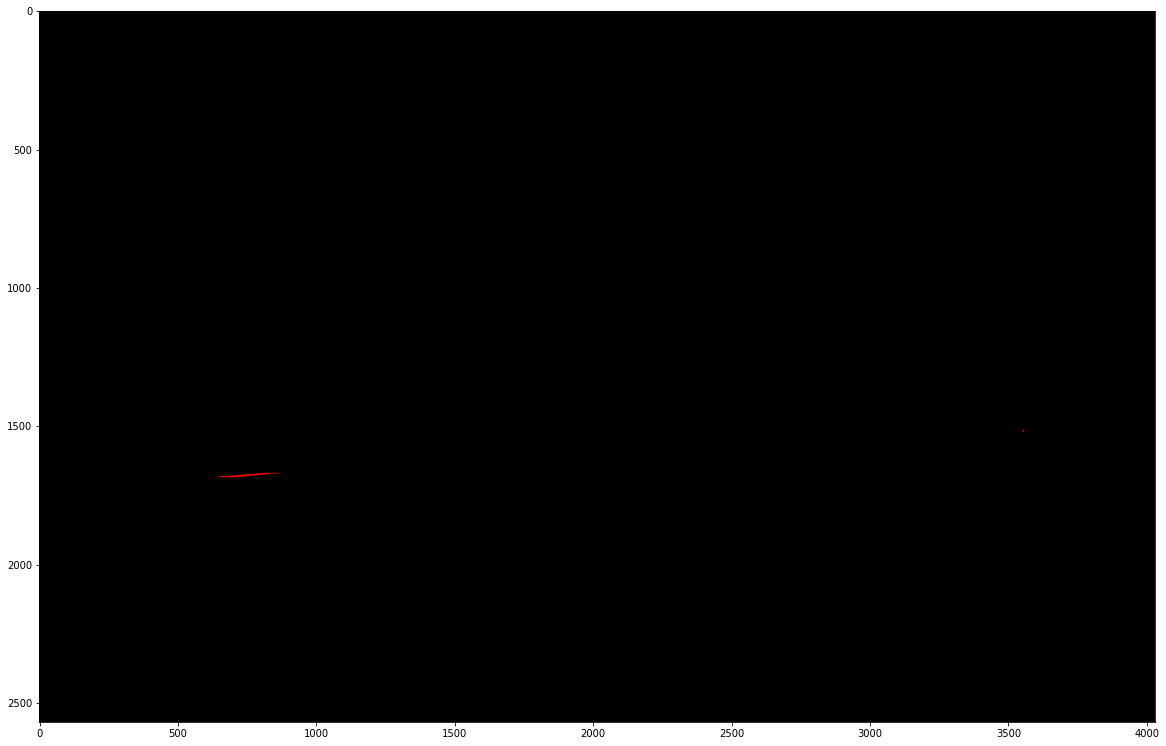

In [12]:
plane = cv2.imread("output.png", cv2.IMREAD_UNCHANGED)

svg_plane = plane[:, :, 3] == 0

#plot(svg_plane, cmap="gray")

from scipy.ndimage import rotate

landscape = rotate(new_img, 90)
#plot(landscape, cmap="gray")
landscape.shape

def to_rgb(grayscale_image):
    bool_rgb = np.repeat(grayscale_image.reshape((grayscale_image.shape[0],grayscale_image.shape[1],1)), 3, axis=2)
    numeric_rgb = bool_rgb * np.ones_like(bool_rgb, dtype=int) * 255
    return numeric_rgb
    

full = np.logical_and(landscape, svg_plane)
full = to_rgb(full)
#plot(full, cmap="gray")

intersection = np.logical_or(landscape, svg_plane)
intersection_inv = np.logical_not(intersection)
intersection = to_rgb(intersection)


intersection[:, :, 0] = 255
intersection = intersection_inv.reshape((intersection_inv.shape[0], intersection_inv.shape[1], 1)) * intersection

plot(intersection)

combined = np.logical_or(intersection == 255, full == 255)
combined = combined * np.ones_like(combined, dtype=int) * 255
plot(combined)

#print(intersection[1670:1680, 750:760])
#print(combined[1670:1680, 750:760])

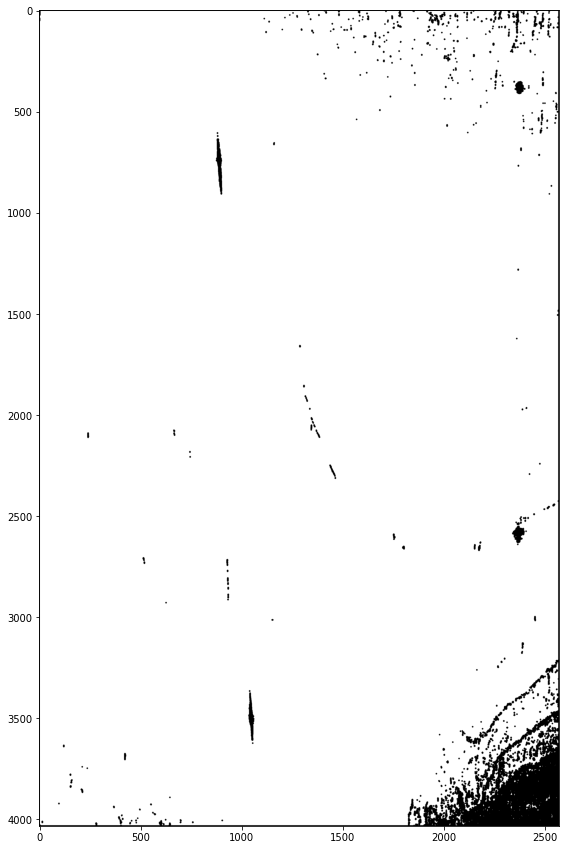

In [13]:
img = new_img.astype(np.uint8)
contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

color = 0

for i in range(len(hierarchy[0])):
    img = cv2.drawContours(img, contours, hierarchy[0][i][0], color, thickness=5)
plot(img, cmap="gray")

In [37]:
hierarchy.shape

(1, 1360, 4)

### Scoring

In [6]:
# x = 2300
# y = 300  # knot in wood

x = 2150
y = 1600  # very clear age line

# x = 100
# y = 1200  # less clear age line. Doesn't really work

# x = 300
# y = 1200  # no age lines
size = 200

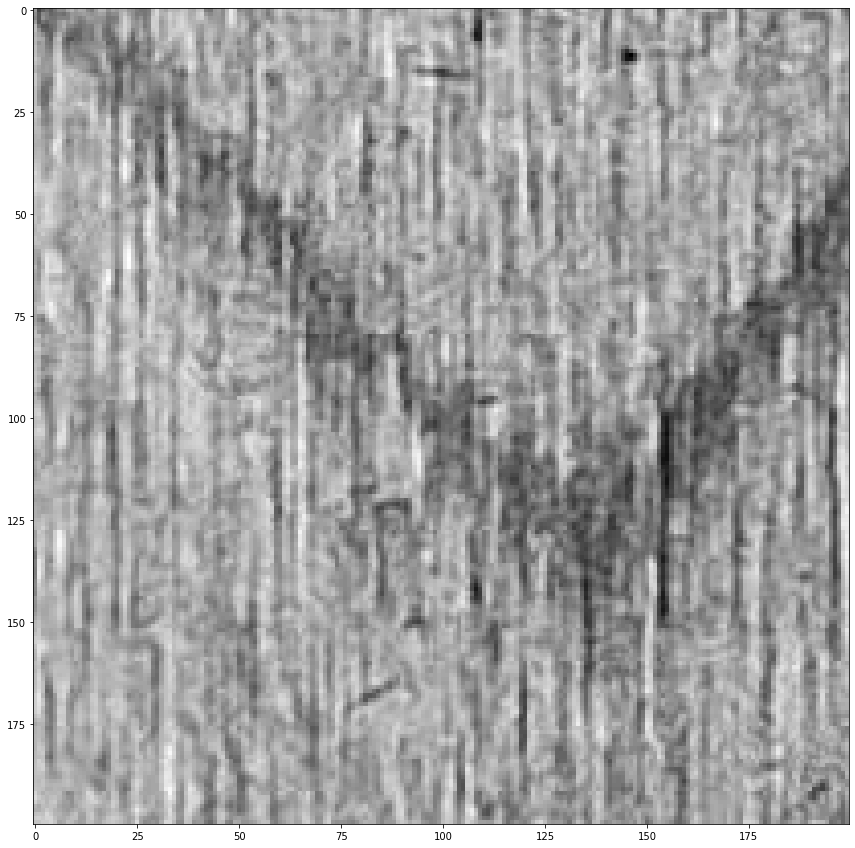

In [7]:
img_bgr = cv2.imread("images/cropartlight2-f.jpg")
gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

sample = gray[y:(y+size), x:(x+size)]
plot(sample, cmap="gray")

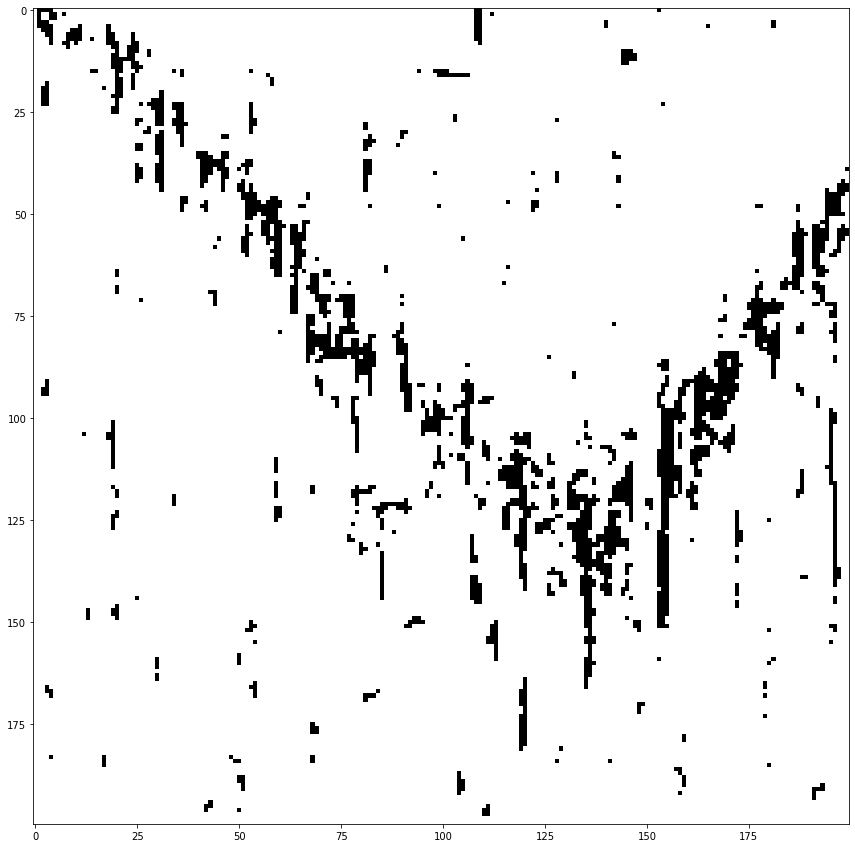

In [9]:
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 1005, 14)

tsample = thresh[y:(y+size), x:(x+size)]
plot(tsample, cmap="gray")

### Pixelation

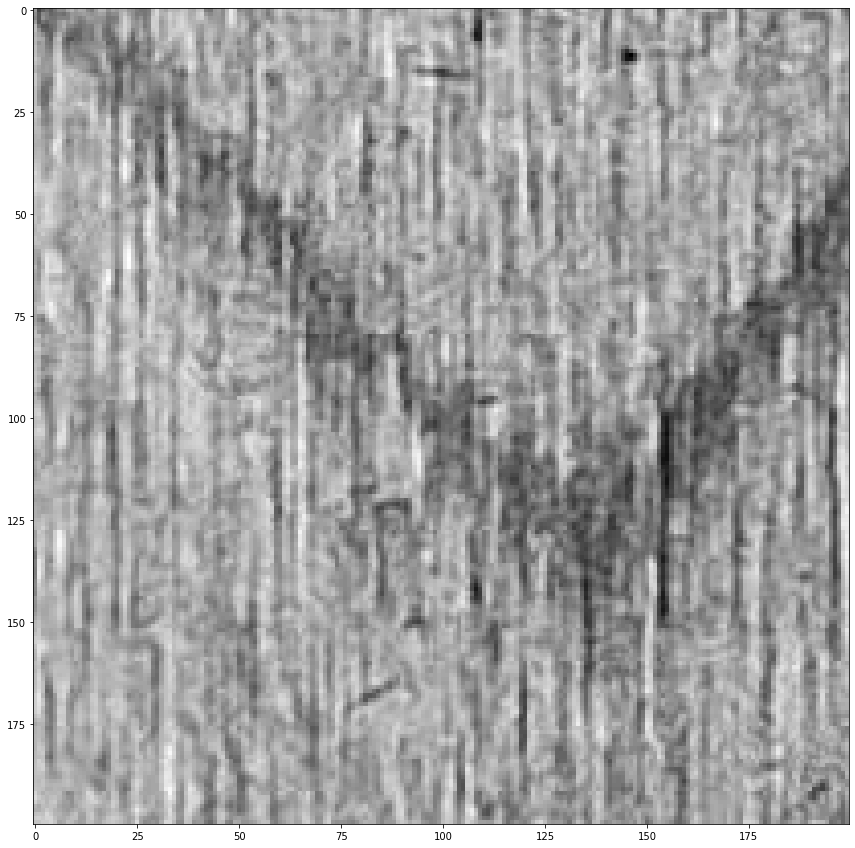

In [16]:
import math

ss_size = 1
pixelated = np.zeros((size, size))
avg_values = []

for i in range(0, size, ss_size): 
    for j in range(0, size, ss_size): 
        avg_value = math.floor(np.sum(sample[i:i+ss_size, j:j+ss_size])/(ss_size ** 2))
        avg_values.append(avg_value)
        pixelated[i:i+ss_size, j:j+ss_size] = np.full((ss_size, ss_size), avg_value)
        
    
plot(pixelated, cmap="gray")

In [17]:
np.array(avg_values).reshape((size // ss_size, size // ss_size))

array([[180, 158, 165, ..., 190, 174, 168],
       [177, 163, 176, ..., 192, 178, 171],
       [175, 163, 179, ..., 192, 182, 176],
       ...,
       [191, 192, 191, ..., 168, 167, 175],
       [194, 195, 193, ..., 170, 167, 174],
       [192, 192, 194, ..., 174, 167, 174]])

<BarContainer object of 67 artists>

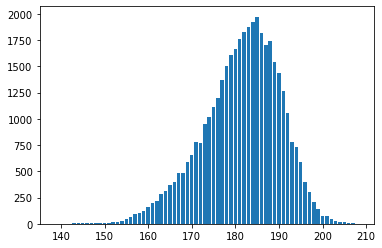

In [18]:
from collections import Counter

c = Counter(avg_values)
x = list(c.keys())
height = list(c.values())

plt.bar(x, height)

In [88]:
import kmeans1d

clustered = kmeans1d.cluster(avg_values, 2)

print(np.mean(avg_values))
print(np.std(avg_values))
print(clustered.centroids)

217.125
1.5360257159305635
[216.24390243902437, 218.69565217391306]


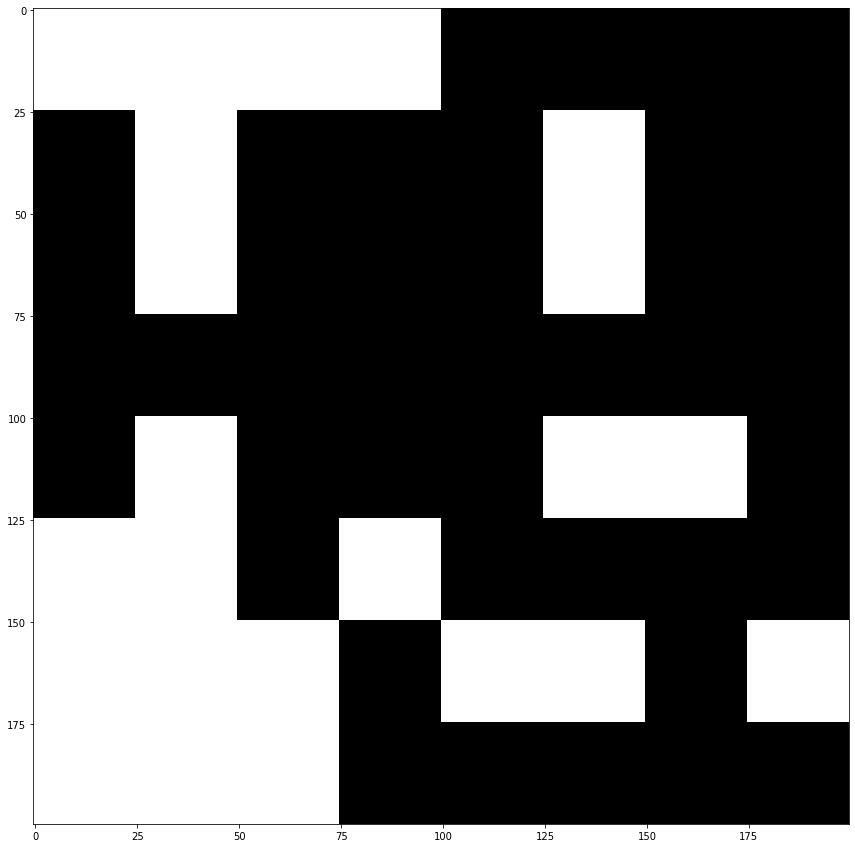

In [89]:
sample_average = np.mean(avg_values)
age_zones = pixelated > sample_average
age_zones_inv = pixelated < sample_average
plot(age_zones, cmap="gray")

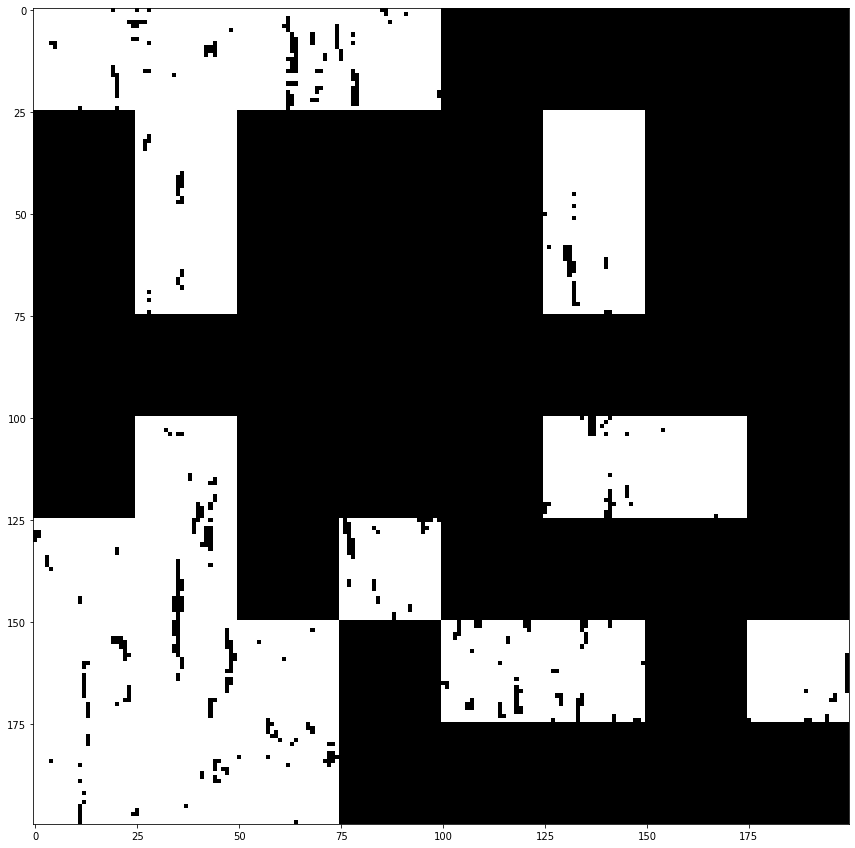

In [90]:
plot(age_zones * tsample, cmap="gray")

In [91]:
age_zones * tsample

array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0]], dtype=uint8)

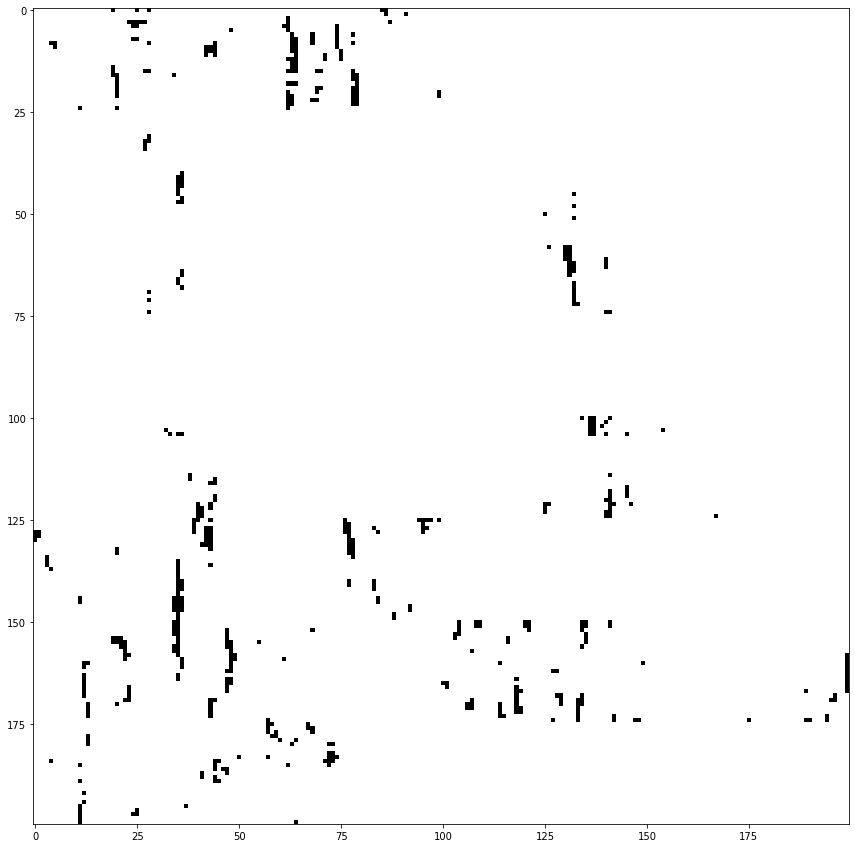

In [92]:
plot(age_zones * tsample + age_zones_inv * 255, cmap="gray")

In [93]:
np.sum(age_zones * tsample + age_zones_inv * 255 == 0) / size ** 2

0.01425

In [94]:
plot(gray_trunc, cmap="gray")

NameError: name 'gray_trunc' is not defined

In [ ]:
gray.shape

In [ ]:
import math

gray_trunc_height = gray.shape[0] - (gray.shape[0] % 25)
gray_trunc_width = gray.shape[1] - (gray.shape[1] % 25)
gray_trunc = gray[0:gray_trunc_height, 0:gray_trunc_width]

ss_size = 25
pixelated = np.zeros(gray_trunc.shape)
avg_values = []

for i in range(0, gray_trunc.shape[0], ss_size): 
    for j in range(0, gray_trunc.shape[1], ss_size): 
        avg_value = math.floor(np.sum(gray_trunc[i:i+ss_size, j:j+ss_size])/(ss_size ** 2))
        avg_values.append(avg_value)
        pixelated[i:i+ss_size, j:j+ss_size] = np.full((ss_size, ss_size), avg_value)
        
    
plot(pixelated, cmap="gray")

### Layering front and back

In [96]:
img_bgr = cv2.imread("images/cropartlight2-f.jpg")
grayf = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

img_bgr = cv2.imread("images/cropartlight2-b.jpg")
grayb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)


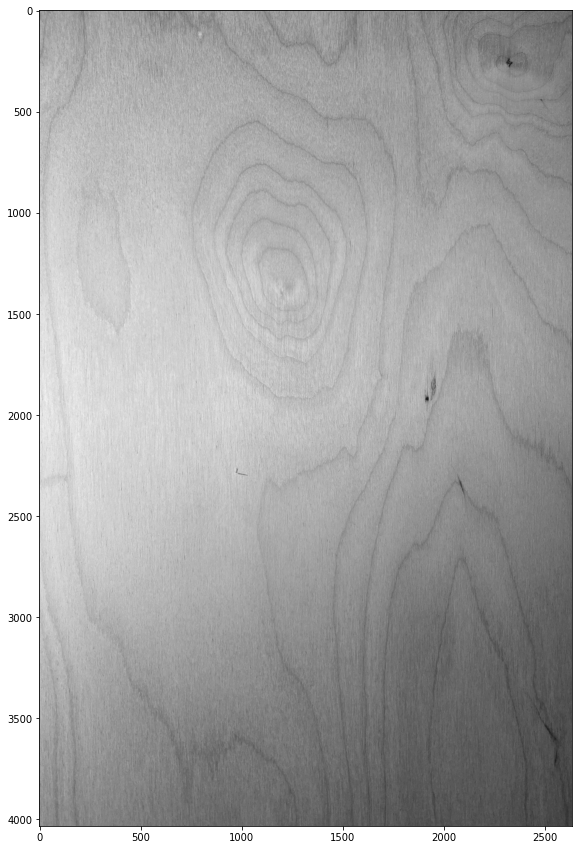

In [97]:
plot(grayb, cmap="gray")

In [98]:
print(grayf.shape)
print(grayb.shape)

(4032, 2568)
(4032, 2632)


In [99]:
img_bgr = cv2.imread("images/cropartlight3-f.jpg")
grayf = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

img_bgr = cv2.imread("images/cropartlight3-b.jpg")
grayb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)


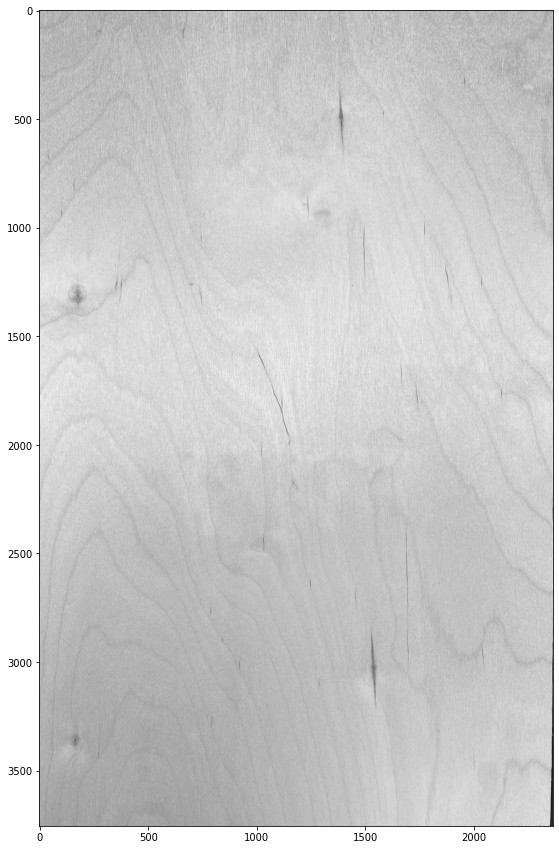

In [100]:
plot(grayf, cmap="gray")

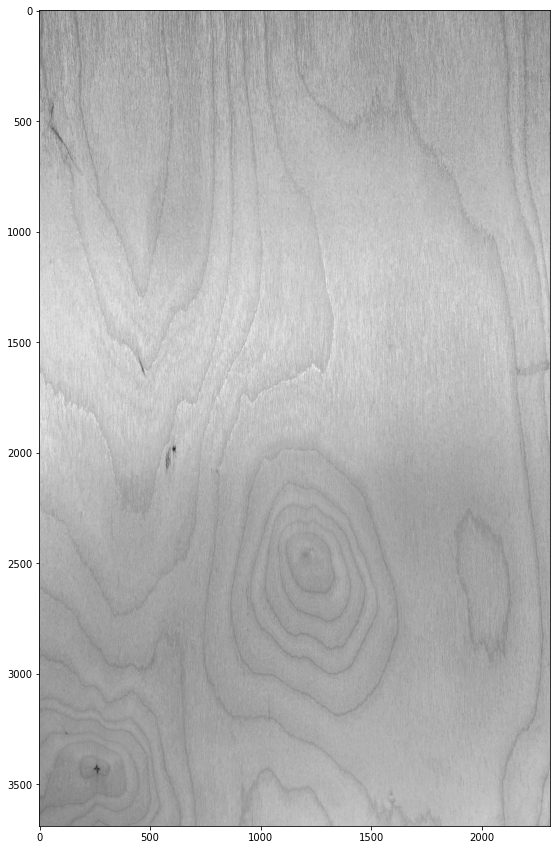

In [101]:
plot(grayb, cmap="gray")

In [102]:
print(grayf.shape)
print(grayb.shape)

(3755, 2364)
(3688, 2308)


In [103]:
grayf = grayf[0:3688, 0:2308]

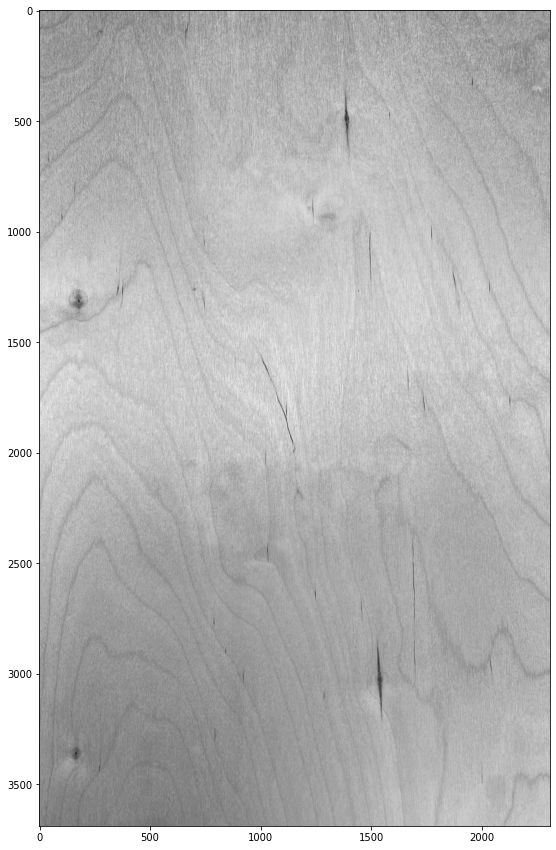

In [104]:
plot(grayf, cmap="gray")

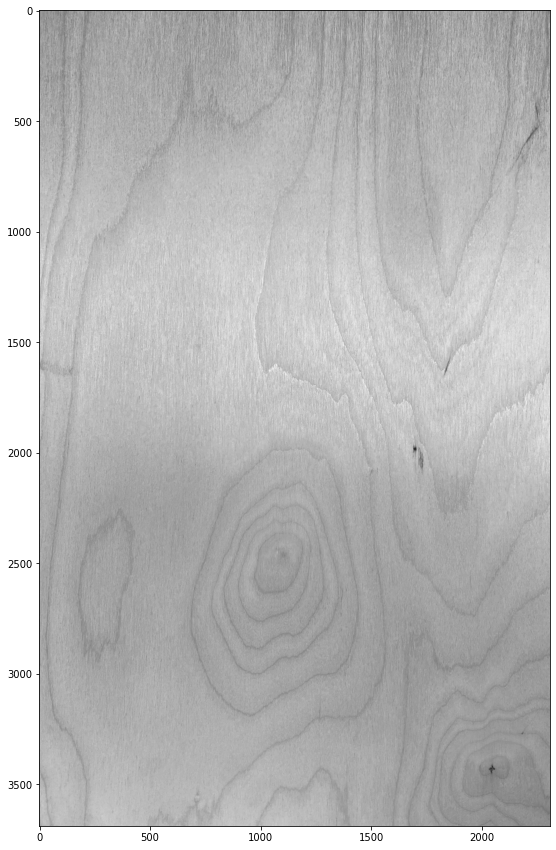

In [105]:
grayb = cv2.flip(grayb, 1)
plot(grayb, cmap="gray")

In [106]:
def applyAdaptiveThreshold(img): 
    return cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 1005, 14)

grayf_thresh = applyAdaptiveThreshold(grayf)
grayb_thresh = applyAdaptiveThreshold(grayb)

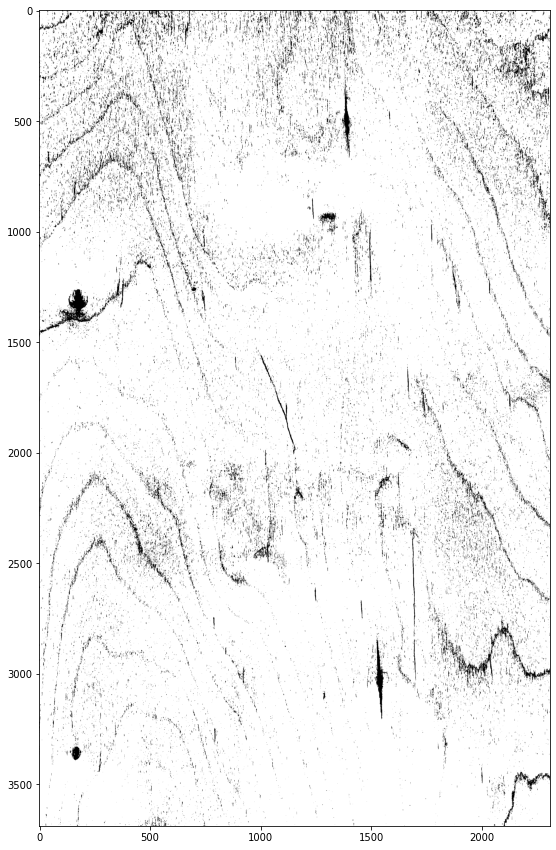

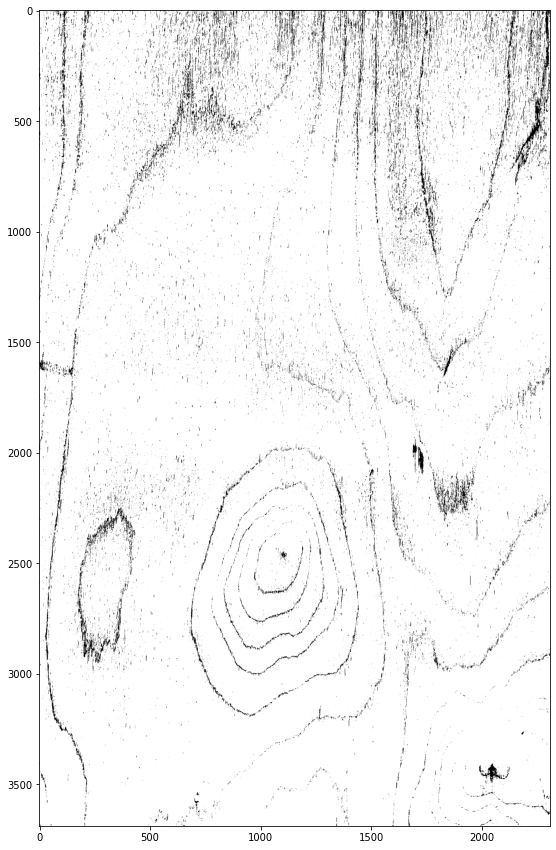

In [107]:
plot(grayf_thresh, cmap="gray")
plot(grayb_thresh, cmap="gray")

(-0.5, 2307.5, 3687.5, -0.5)

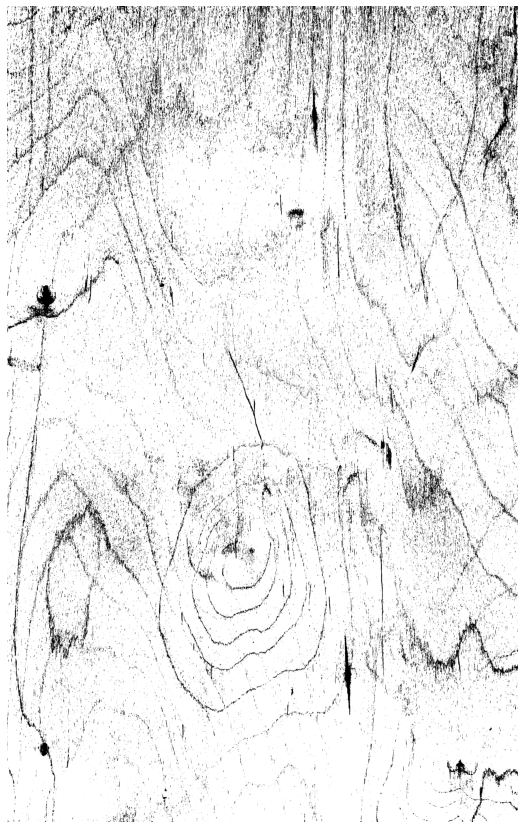

In [108]:
plot(grayf_thresh * grayb_thresh / 255, cmap="gray")
plt.axis("off")

### Parsing SVG